# Lead-Lag Path Augmentation Example

This notebook demonstrates how to create a lead-lag transformation using:
1. A Brownian motion driver
2. An Riemann-Liouville driver derived from the Brownian motion
3. A lead-lag path with Brownian leading and RL lagging following https://arxiv.org/abs/2412.21192

We will first compute a new correlated Brownian motions $\tilde{W}$ from two initial Brownians $\{ W_i \}_{i=0}^{n-1}, \{ B_i \}_{i=0}^{n-1}$ using the formula
$$
\tilde{W} = \rho dW_s + \sqrt{1 - \rho^2} dB_s.
$$

We will set our correlation parameter $\rho = -0.848$ following [1]


In [51]:
import jax
import jax.numpy as jnp
from stochastax.rdes.drivers import bm_driver, correlate_bm_driver_against_reference
import matplotlib.pyplot as plt

rho = -0.848

timesteps = 1000
dim = 1

key = jax.random.key(4)
keys = jax.random.split(key, 2)

w_path = bm_driver(keys[0], timesteps, dim)
b_path = bm_driver(keys[1], timesteps, dim)

correlated_path = correlate_bm_driver_against_reference(w_path, b_path, rho)

Lets then plot the three Brownians we have generated and their correlations

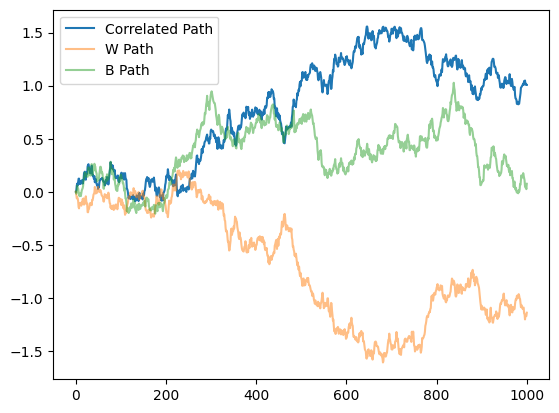

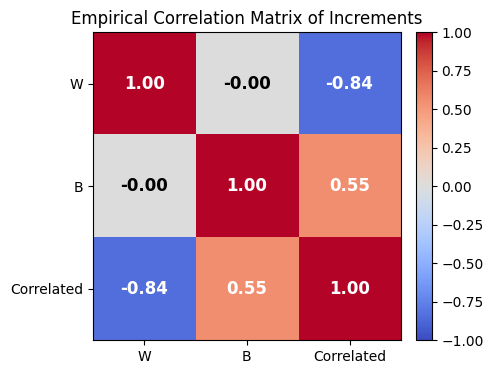

In [52]:
plt.plot(correlated_path.path, label="Correlated Path")
plt.plot(w_path.path, label="W Path", alpha=0.5)
plt.plot(b_path.path, label="B Path", alpha=0.5)
plt.legend()
plt.show()

# Compute increments
w_increments = jnp.diff(w_path.path, axis=0).flatten()
b_increments = jnp.diff(b_path.path, axis=0).flatten()
corr_increments = jnp.diff(correlated_path.path, axis=0).flatten()

# Stack increments for correlation matrix
increments_matrix = jnp.stack([w_increments, b_increments, corr_increments], axis=0)
emp_corr_matrix = jnp.corrcoef(increments_matrix)

# Plot the empirical correlation matrix with correlation coefficients
plt.figure(figsize=(5, 4))
im = plt.imshow(emp_corr_matrix, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks([0, 1, 2], ["W", "B", "Correlated"])
plt.yticks([0, 1, 2], ["W", "B", "Correlated"])
plt.title("Empirical Correlation Matrix of Increments")

# Annotate correlation coefficients on the plot
for i in range(emp_corr_matrix.shape[0]):
    for j in range(emp_corr_matrix.shape[1]):
        _ = plt.text(
            j,
            i,
            f"{emp_corr_matrix[i, j]:.2f}",
            ha="center",
            va="center",
            color="white" if abs(emp_corr_matrix[i, j]) > 0.5 else "black",
            fontsize=12,
            fontweight="bold",
        )

plt.show()

## Computing the Riemann-Liouville Process
As you can see above, we now have a new Brownian driver $\tilde{W}$ correlated to $W$ by $\rho$ and $B$ by $\sqrt{1 - \rho^2}$. We can then use $\tilde{W}$ to generate a Riemann Liouville process via:
$$
X_t = \frac{1}{\Gamma(H+\frac{1}{2})} \int_0^t (t-s)^{H-\frac{1}{2}}d \tilde{W}_s
$$

In the case of the rough Bergomi model $X$ is the volatility process so $X = V$.

Calibration results from [1] recommend a Hurst parameter of $H=0.0996$, which is outside the range of $H$ which can be treated by rough paths. As such, we set $H=0.25$, the closest we can get while still converging under the rough path metric.

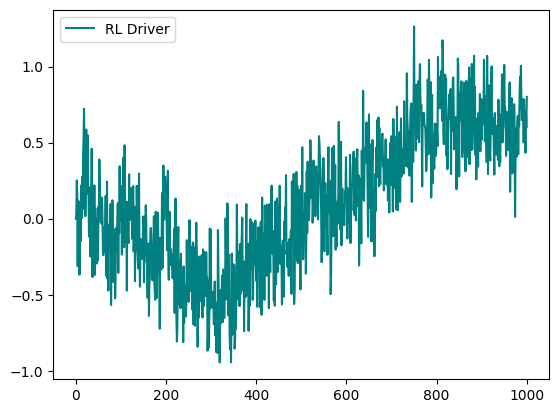

In [53]:
from stochastax.rdes.drivers import riemann_liouville_driver

hurst = 0.25
rl_driver = riemann_liouville_driver(key, timesteps, hurst, correlated_path)
del b_path  ## In the framework of [2], we no longer need the Brownian path B as we will control the volatility by the rl_driver and stock price by w_path

plt.plot(rl_driver.path, color="teal", label="RL Driver")
plt.legend()
plt.show()

## Forming the Lead-Lag Path
In the Framework of [2], we now form a lead-lag path, with the $W$ leading and the Riemann Liouville process lagging


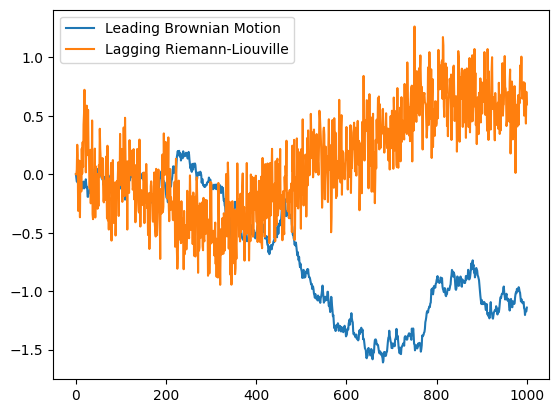

In [54]:
leading_path = w_path.path
lagging_path = jnp.concatenate([rl_driver.path[:1], rl_driver.path[:-1]], axis=0)

plt.plot(leading_path[:, 0], label="Leading Brownian Motion")
plt.plot(lagging_path[:, 0], label="Lagging Riemann-Liouville")
plt.legend()

## Solving the RDE with a Wong-Zakai ODE

In [55]:
tprobe = ts[:: max(1, len(ts) // 10)]
Vlag_tp = jnp.asarray(lag_interp.evaluate(tprobe), dtype=jnp.float64)
exp_arg = eta * Vlag_tp - 0.5 * C * (tprobe ** (2 * hurst))
sigma_tp = jnp.sqrt(v0) * jnp.exp(exp_arg)

print("dtype:", Vlag_tp.dtype)
print("v0 =", float(v0))
print("min/max Vlag:", float(Vlag_tp.min()), float(Vlag_tp.max()))
print("min/max exp_arg:", float(exp_arg.min()), float(exp_arg.max()))
print("min/max sigma:", float(sigma_tp.min()), float(sigma_tp.max()))

dtype: float64
v0 = 0.04
min/max Vlag: -0.38690293995588526 1.1260905510088073
min/max exp_arg: -2.090235620183682 2.2420462870585354
min/max sigma: 0.02473159921297723 1.8825144838836942


In [ ]:
from diffrax import LinearInterpolation
import diffrax
from jax.scipy.special import gamma

N = w_path.path.shape[0]
ts = jnp.linspace(0.0, 1.0, N)
lead_interp = LinearInterpolation(ts=ts, ys=leading_path.ravel())

lag_interp = LinearInterpolation(ts=ts, ys=lagging_path)


## Diffrax Solver
v0 = 0.04
eta = 1.991
Gamma = gamma(hurst + 0.5)
C = (eta**2) / (Gamma**2)


def sigma(t):
    v_t = jnp.squeeze(lag_interp.evaluate(t))
    return jnp.sqrt(v0) * jnp.exp(eta * v_t - 0.5 * C * (t ** (2 * hurst)))


def g(t):
    v_t = jnp.squeeze(lag_interp.evaluate(t))
    return -0.5 * v0 * jnp.exp(2 * eta * v_t - C * (t ** (2 * hurst)))


def vf(t, y, args):
    # ControlTerm vector field: returns shape (state_dim,) for 1D control
    return sigma(t) * y


def f0(t, y, args):
    # ODETerm (drift)
    return g(t) * y


term = diffrax.MultiTerm(
    diffrax.ODETerm(f0),
    diffrax.ControlTerm(vf, control=lead_interp),  # lead control only
)

solver = diffrax.Heun()  # Euler/Heun are fine for piecewise-constant slopes
sol = diffrax.diffeqsolve(
    term,
    solver=solver,
    t0=ts[0],
    t1=ts[-1],
    dt0=0.001,
    stepsize_controller=diffrax.ConstantStepSize(),
    y0=1.0,
    saveat=diffrax.SaveAt(ts=ts),
    max_steps=None,
)
S_vals = sol.ys

In [57]:
W_vals = leading_path.squeeze()  # levels (N_samp,)
N_samp = W_vals.shape[0]
ts = jnp.linspace(0.0, 1.0, N_samp)  # match lengths

dts = jnp.diff(ts)
Δ = dts[0]
print("len ts / len W:", ts.shape[0], N_samp)
print("uniform grid?", jnp.allclose(dts, Δ))
print("Δ =", float(Δ))

slopes = jnp.diff(W_vals) / Δ  # piecewise-constant derivative
print("Tail slopes:", slopes[-5:])

# Sanity: derivative from the interpolation agrees with the slope
import diffrax as dfx

lead_interp = dfx.LinearInterpolation(ts=ts, ys=W_vals)
k = N_samp - 2  # last interval index
tmid = 0.5 * (ts[k] + ts[k + 1])
eps = 1e-6 * Δ
fd = (lead_interp.evaluate(tmid + eps) - lead_interp.evaluate(tmid - eps)) / (2 * eps)
print("Interp finite-diff derivative near end vs slope:", float(fd), float(slopes[k]))

len ts / len W: 1001 1001
uniform grid? True
Δ = 0.001
Tail slopes: [-53.46544199  34.67611422  -4.04244955   0.8584765   31.65433465]
Interp finite-diff derivative near end vs slope: 31.654333820796406 31.65433465245604


In [60]:
# 1) Check the slope variance matches 1/Δ (≈ true in expectation)
import jax.numpy as jnp

var_slopes = jnp.var(slopes)
print("var(slopes) * Δ ≈", float(var_slopes * Δ))  # should be ≈ 1

# 2) Verify you're really using the delayed V in the vector field
V_vals = rl_driver.path.squeeze()
Vlag_vals = jnp.concatenate([V_vals[:1], V_vals[:-1]], axis=0)
same_prev_incr = jnp.allclose(
    jnp.diff(Vlag_vals)[1:],  # increments of the lag
    jnp.diff(V_vals)[:-1],  # previous increments of the original
)
print("Lag uses previous increment?", bool(same_prev_incr))

var(slopes) * Δ ≈ 0.9707307134924398
Lag uses previous increment? True


In [61]:
sigma_grid = jnp.array([sigma(float(t)) for t in ts])
print(
    "sigma min/median/max:",
    float(sigma_grid.min()),
    float(jnp.median(sigma_grid)),
    float(sigma_grid.max()),
)

sigma min/median/max: 0.014047891726886565 0.10745209027275374 0.7885731338001009


1001


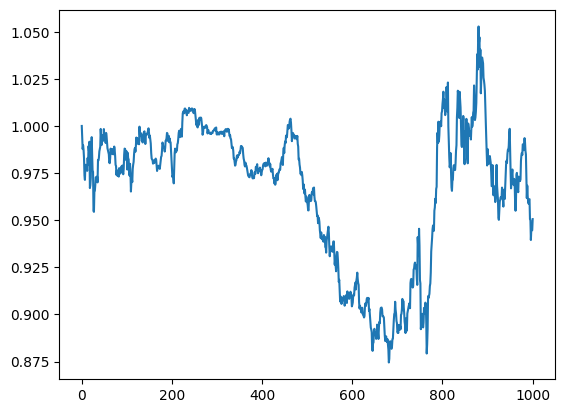

In [59]:
plt.plot(S_vals)
print(len(S_vals))

## References

[1] R. Callum, “The Rough Bergomi Model: From Motivation to Implemenetation,” Master’s Thesis, Imperial College London, London, 2023. [Online]. Available: https://www.imperial.ac.uk/media/imperial-college/faculty-of-natural-sciences/department-of-mathematics/math-finance/212261203---Callum-Rough---ROUGH_CALLUM_01333836.pdf

[2] O. Bonesini, E. Ferrucci, I. Gasteratos, and A. Jacquier, “Rough differential equations for volatility.” 2024. [Online]. Available: https://arxiv.org/abs/2412.21192